In [1]:
# standard data science libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# autograd modules
from autograd import nn, utils
from autograd.engine import Scalar
from autograd.visualize import draw_graph

In [3]:
# get toy dataset
from sklearn.datasets import make_moons, make_blobs

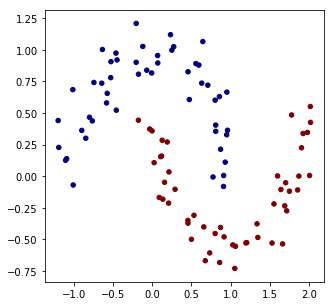

In [4]:
# prepare and visualze data
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
# create feed-forward multi-layer perceptron
# - 2 dimensional input data
# - 2 layers of 16 hidden units each
# - 1 unit output layer
model = nn.MLP(2, [16,16,1])
print(model)
print(f"\nNumber of trainable parameters: {len(model.parameters())}")

MLP([Layer([ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2)]),Layer([ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16)]),Layer([LinearNeuron(16)])])

Number of trainable parameters: 337


In [12]:
# define loss function
def calculate_loss(batch_size=None):
    if not batch_size:
        Xb, yb = X, y
    else:
        random_indexes = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[random_indexes], y[random_indexes]
    
    # initialize inputs as Scalars
    inputs = [list(map(Scalar, row)) for row in Xb]
    
    # forward propagation
    outputs = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = utils.svm_max_margin_loss(outputs, yb)
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # L2 regularization (adding sum of squares of weights to penalize large weights, times hyperparameter alpha)
    reg_loss = utils.l2_regularization(model, alpha=1e-4)
    total_loss = data_loss + reg_loss

    # calculate
    accuracy = [(y_i > 0) == (output_i.value > 0) for y_i, output_i in zip(yb, outputs)]
    return total_loss, sum(accuracy) / len(accuracy)

In [13]:
# training
def train(epochs=100, debug=False):
    for epoch in range(epochs):
        total_loss, accuracy = calculate_loss()
        
        # zero out previous gradients for next iteration of backpropagation
        model.zero_grad()
        
        # backprop
        total_loss.backward()
        
        # update parameters (stochastic gradient descent with learning rate decay)
        learning_rate = 1.0 - 0.9*epoch/100
        
        for parameter in model.parameters():
            if debug:
                print('before',parameter.value,'grad',parameter.grad)
            parameter.value -= learning_rate * parameter.grad
            if debug:
                print('after',parameter.value)
        if epoch % 5 == 0:
            print(f"Epoch: {epoch}, Loss: {total_loss.value}, Accuracy: {accuracy*100}%")

In [14]:
train()

Epoch: 0, Loss: 1.1811447893137088, Accuracy: 50.0%
Epoch: 5, Loss: 0.34252293627515423, Accuracy: 85.0%
Epoch: 10, Loss: 0.23232275148840936, Accuracy: 88.0%
Epoch: 15, Loss: 0.16335311058493526, Accuracy: 93.0%
Epoch: 20, Loss: 0.09401348257978732, Accuracy: 98.0%
Epoch: 25, Loss: 0.21481892641686806, Accuracy: 94.0%
Epoch: 30, Loss: 0.0342738038469022, Accuracy: 100.0%
Epoch: 35, Loss: 0.08255695819419387, Accuracy: 98.0%
Epoch: 40, Loss: 0.018457989369988163, Accuracy: 100.0%
Epoch: 45, Loss: 0.01705155569299891, Accuracy: 100.0%
Epoch: 50, Loss: 0.013652559141190363, Accuracy: 100.0%
Epoch: 55, Loss: 0.013541461554148935, Accuracy: 100.0%
Epoch: 60, Loss: 0.013849418545623646, Accuracy: 100.0%
Epoch: 65, Loss: 0.012107786113475898, Accuracy: 100.0%
Epoch: 70, Loss: 0.012237104489140005, Accuracy: 100.0%
Epoch: 75, Loss: 0.011627614020528738, Accuracy: 100.0%
Epoch: 80, Loss: 0.011563488364613843, Accuracy: 100.0%
Epoch: 85, Loss: 0.011192800890495631, Accuracy: 100.0%
Epoch: 90, L

(-1.548639298268643, 1.951360701731357)

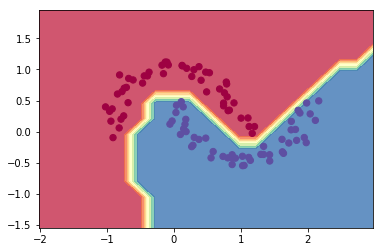

In [13]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Scalar, xrow)) for xrow in Xmesh]
outputs = list(map(model, inputs))
Z = np.array([output.value > 0 for output in outputs])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())